## 1. Setup and Preprocessing

In [78]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [80]:
import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("CUDA is not available. Using CPU.")

check_cuda()

CUDA is available. Using GPU: Tesla T4


In [81]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [82]:
# !pip install evaluate

In [83]:
# pip install -U bitsandbytes

In [84]:
# exit()

In [85]:
# !apt-get install -y ninja-build

In [86]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
import os


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login

In [87]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory to the NLP folder in your Drive
nlp_folder = Path('/content/drive/My Drive/NLP')
os.chdir(nlp_folder)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path (now the NLP folder)
basepath = nlp_folder

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder'
model_folder = Path(basepath) / 'lect 7' / 'assignment 7'/ 'sentiment' / 'nn' # Updated path
custom_functions = Path(basepath) / 'lect 7' / 'assignment 7' /'CustomFiles'  # Updated path

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/My Drive/NLP
Model folder created: True
Custom functions folder created: True


In [88]:
set_seed(69)

In [89]:
model_folder.mkdir(exist_ok=True, parents = True)

In [90]:
import wandb

# Log into WandB
wandb.login()

wandb: Currently logged in as: shobhit-pachauri (shobhit-pachauri-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


True

In [91]:
from huggingface_hub import login

login()

In [92]:
model_folder

PosixPath('/content/drive/My Drive/NLP/lect 7/assignment 7/sentiment/nn')

In [93]:
import pandas as pd
import numpy as np
train_dataset = pd.read_csv(data_folder /'train.csv',usecols=lambda column: column != 'ID')

In [94]:
type(train_dataset)

pandas.core.frame.DataFrame

In [95]:
train_dataset.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [96]:
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [97]:
len(label_columns)

11

In [98]:
selected_columns = {
    'text': train_dataset['Tweet'],
    'label': train_dataset[label_columns].values.tolist()}

tweet_selected_columns = Dataset.from_dict(selected_columns)

In [99]:
tweet_selected_columns.set_format(type='pandas')

In [100]:
df = tweet_selected_columns[:]

In [101]:
df

,text,label
0,“Worry is a down payment on a problem you may ...,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1,Whatever you decide to do make sure it makes y...,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]"
2,@Max_Kellerman it also helps that the majorit...,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0]"
3,Accept the challenges so that you can literall...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
4,My roommate: it's okay that we can't spell bec...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
7719,@BadHombreNPS @SecretaryPerry If this didn't m...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
7720,Excited to watch #stateoforigin tonight! Come ...,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]"
7721,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
7722,#ThingsIveLearned The wise #shepherd never tru...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [102]:
df_final = Dataset.from_pandas(df)

In [103]:
df_final

Dataset({
    features: ['text', 'label'],
    num_rows: 7724
})

In [104]:
test_val_splits = df_final.train_test_split(test_size=0.3, seed=36)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=36)
val_split = test_val_splits['train']
test_split = test_val_splits['test']

In [105]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [106]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1159
    })
})

## 2. Tokenization

In [107]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [108]:
free_gpu_memory()

GPU memory has been freed.


In [109]:
checkpoint = "meta-llama/Llama-3.2-1b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [110]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [111]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [112]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1159
    })
})

In [113]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [114]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 1159
    })
})

In [115]:
tokenized_dataset['train']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## 3. Model Download

In [116]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [117]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.float16

In [118]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [119]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
config.id2label = id2label
config.label2id = label2id
model.config = config

## 4. PEFT Setup

In [121]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [122]:
find_linear_layers(model)

['model.layers.0.self_attn.q_proj',
 'model.layers.0.self_attn.k_proj',
 'model.layers.0.self_attn.v_proj',
 'model.layers.0.self_attn.o_proj',
 'model.layers.0.mlp.gate_proj',
 'model.layers.0.mlp.up_proj',
 'model.layers.0.mlp.down_proj',
 'model.layers.1.self_attn.q_proj',
 'model.layers.1.self_attn.k_proj',
 'model.layers.1.self_attn.v_proj',
 'model.layers.1.self_attn.o_proj',
 'model.layers.1.mlp.gate_proj',
 'model.layers.1.mlp.up_proj',
 'model.layers.1.mlp.down_proj',
 'model.layers.2.self_attn.q_proj',
 'model.layers.2.self_attn.k_proj',
 'model.layers.2.self_attn.v_proj',
 'model.layers.2.self_attn.o_proj',
 'model.layers.2.mlp.gate_proj',
 'model.layers.2.mlp.up_proj',
 'model.layers.2.mlp.down_proj',
 'model.layers.3.self_attn.q_proj',
 'model.layers.3.self_attn.k_proj',
 'model.layers.3.self_attn.v_proj',
 'model.layers.3.self_attn.o_proj',
 'model.layers.3.mlp.gate_proj',
 'model.layers.3.mlp.up_proj',
 'model.layers.3.mlp.down_proj',
 'model.layers.4.self_attn.q_proj',


In [123]:
for name, module in model.named_modules():
    print(name, module)

 LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2

In [124]:
# 1. Import necessary modules
from peft import LoraConfig, TaskType, get_peft_model
from transformers import BitsAndBytesConfig

# 2. Quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

# 3. Corrected LoRA config
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,                    # LoRA attention dimension
    lora_alpha=256,          # Alpha parameter for LoRA scaling
    lora_dropout=0.01,
    bias="all",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Target attention modules
    # Removed modules_to_save as it was causing the error
    inference_mode=False
)

# 4. Apply LoRA
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 27,285,504 || all params: 1,263,122,432 || trainable%: 2.1602


In [125]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [126]:
free_gpu_memory()

GPU memory has been freed.


In [127]:
checkpoint = "meta-llama/Llama-3.2-1b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [128]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True, max_length=512)

In [129]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [130]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1159
    })
})

In [131]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/5406 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [132]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 5406
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 1159
    })
})

In [133]:
tokenized_dataset['train']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## 3. Model Download

In [134]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [135]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.float16

In [136]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [137]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
config.id2label = id2label
config.label2id = label2id
model.config = config

## 4. PEFT Setup

In [139]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [ ]:
find_linear_layers(model)

In [ ]:
for name, module in model.named_modules():
    print(name, module)

In [145]:
# 2. Model loading
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=11,
    problem_type="multi_label_classification",
    trust_remote_code=True,
    quantization_config=quantization_config
)

# 3. Corrected LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,                     # Reduced rank for stability
    lora_alpha=32,           # Alpha scaling
    lora_dropout=0.1,
    bias="none",             # Changed from "all" to "none"
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    inference_mode=False,
    # Removed modules_to_save completely
)

# 4. Apply LoRA
model = prepare_model_for_kbit_training(model)  # Add this line
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 4,528,128 || all params: 1,039,063,040 || trainable%: 0.4358


In [146]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
             

In [ ]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## 5. Training and Validation

In [ ]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/llama-3.2-1b")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'multilabel_tweet_hw7_gemma'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# 1. Tokenizer setup with padding token
tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    padding_side="right",
    pad_token="<pad>",  # Define pad token
    trust_remote_code=True
)

# 2. Add padding token to model
model.config.pad_token_id = tokenizer.pad_token_id
tokenizer.padding_side = "right"

# 3. Resize embeddings to match
model.resize_token_embeddings(len(tokenizer))

# Configure training parameters
training_args = TrainingArguments(
    seed = 69,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.6882,  6.0945,  1.6487,  4.6489,  1.6896,  8.2568,  2.4433,  7.5538,
         2.3268, 17.3878, 18.1025])

In [ ]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
# Add a padding token to your tokenizer if it doesn't have one
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    # If you are using a Peft model, you need to resize the model embeddings
    # after adding the new token to the tokenizer.
    lora_model.resize_token_embeddings(len(tokenizer))

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-232-205d00a764b3>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.103400,1.075021,0.264244,0.197819,0.510785,0.000863
40,1.092900,1.075568,0.274321,0.184061,0.551808,0.001726
60,1.079600,1.072446,0.294420,0.214976,0.558632,0.004314
80,1.094400,1.071718,0.306770,0.226179,0.573535,0.002588
100,1.117000,1.071477,0.295325,0.210592,0.553063,0.004314
120,1.134300,1.072388,0.273876,0.205612,0.481763,0.000863
140,1.080700,1.072067,0.299882,0.262132,0.486156,0.000000
160,1.078900,1.073364,0.343148,0.263484,0.574790,0.000863
180,1.074200,1.071911,0.326966,0.259012,0.574398,0.003451
200,1.096500,1.072991,0.277133,0.188415,0.526159,0.006040


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

## 4. Validation

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 1.0693598985671997,
 'eval_f1_micro': 0.36195063214930767,
 'eval_f1_macro': 0.28830792847526543,
 'eval_accuracy_label': 0.5843595576123618,
 'eval_accuracy_all': 0.007765314926660914,
 'eval_runtime': 2.739,
 'eval_samples_per_second': 423.144,
 'eval_steps_per_second': 13.508,
 'epoch': 2.0}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
valid_logits.shape

(1159, 11)

## 5. Optimizing Thresholds and Accounting for Imbalance

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics

In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)

In [ ]:
optimal_thresholds

[0.47597065567970276,
 0.47469204664230347,
 0.48273393511772156,
 0.49741363525390625,
 0.45677322149276733,
 0.5064388513565063,
 0.4361417889595032,
 0.4749355614185333,
 0.4413125813007355,
 0.4625944197177887,
 0.48121002316474915]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.3853407958291804,
 'f1_macro': 0.3382178345035297,
 'accuracy_label': 0.3711663659894894,
 'accuracy_all': 0.0}

## 6. Confusion Matrix

In [ ]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[  35  697]
  [   7  420]]

 [[  43  951]
  [   1  164]]

 [[  41  685]
  [   6  427]]

 [[ 482  475]
  [  82  120]]

 [[  27  698]
  [   9  425]]

 [[ 557  477]
  [  54   71]]

 [[   9  774]
  [   2  374]]

 [[  65  965]
  [   7  122]]

 [[   2  829]
  [   1  327]]

 [[ 101 1006]
  [   3   49]]

 [[ 857  249]
  [  39   14]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

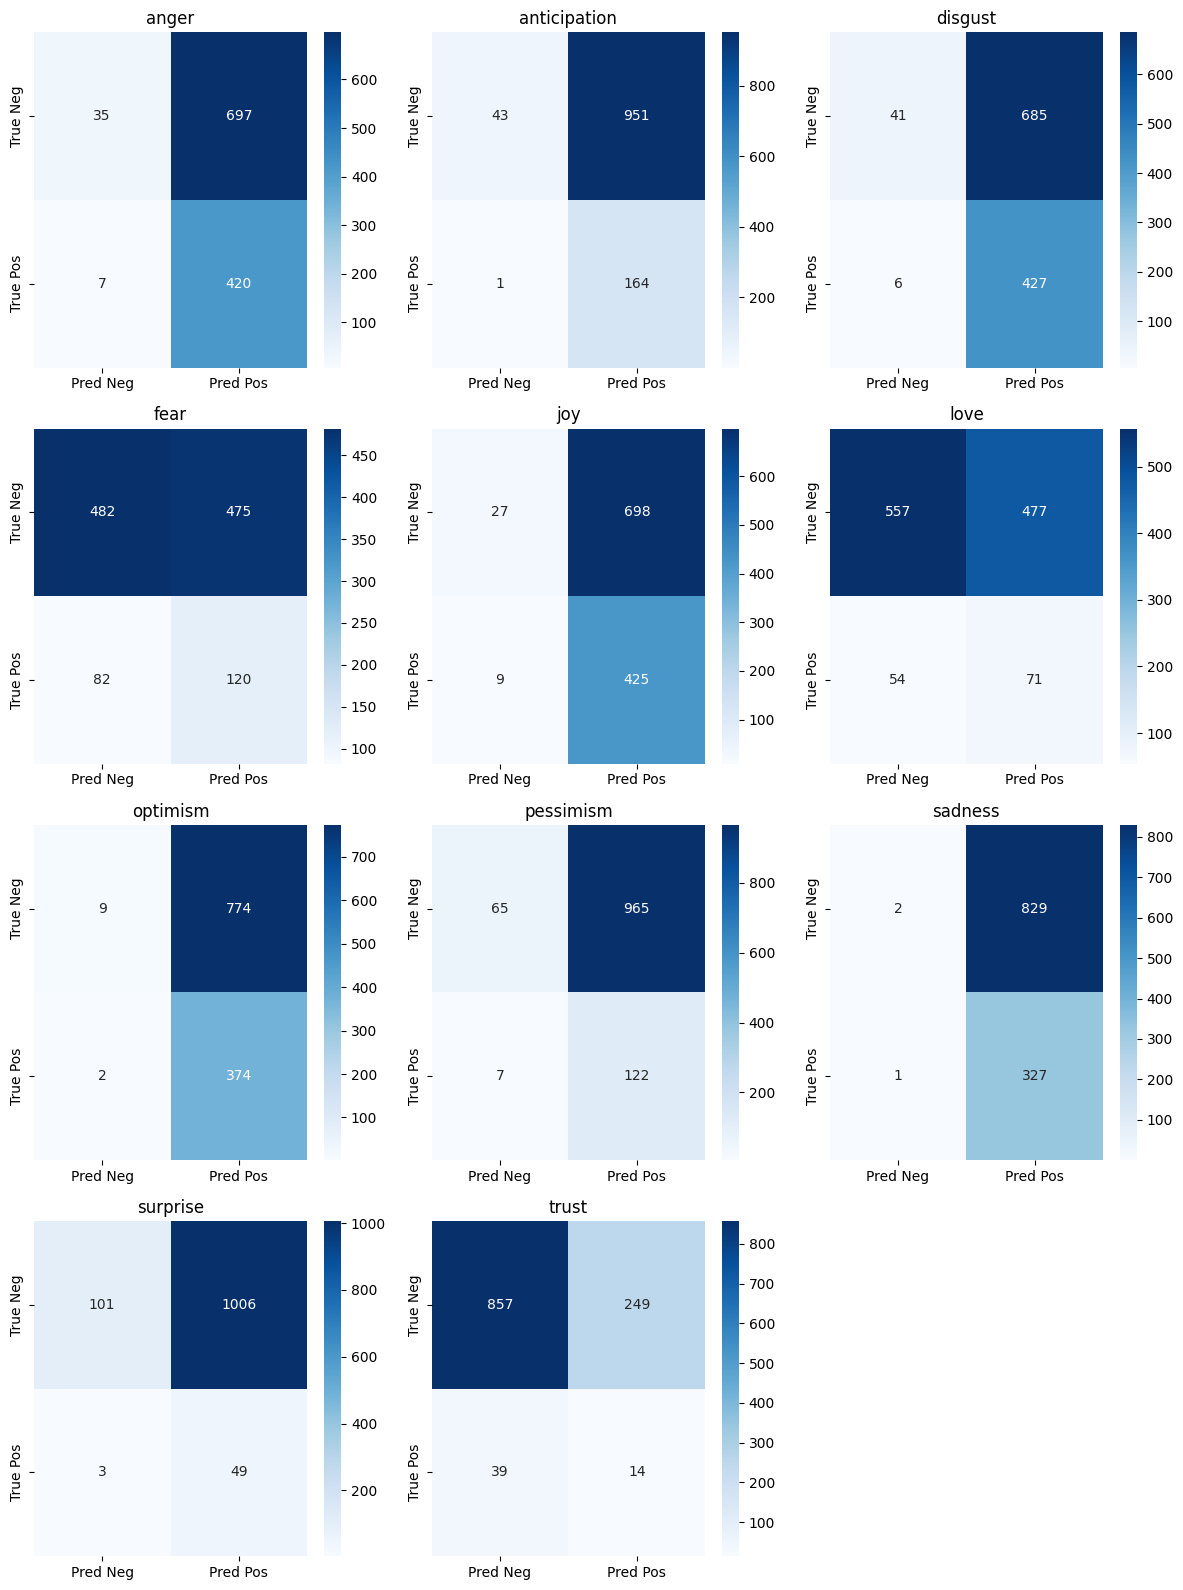

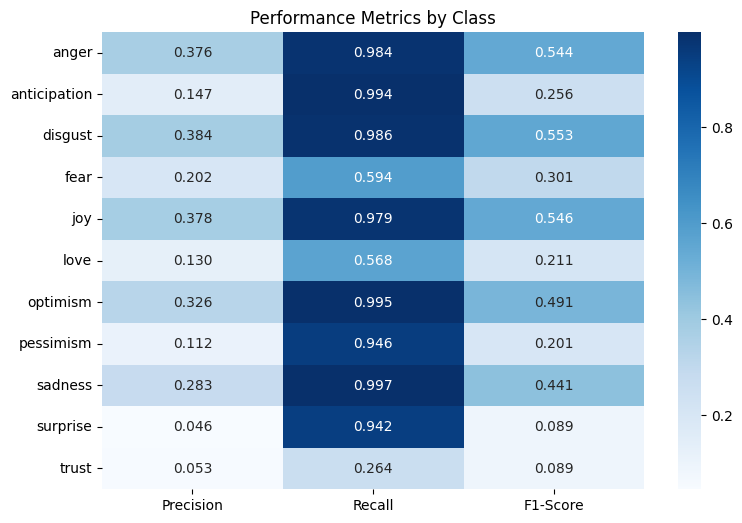

<Figure size 1200x533.333 with 0 Axes>

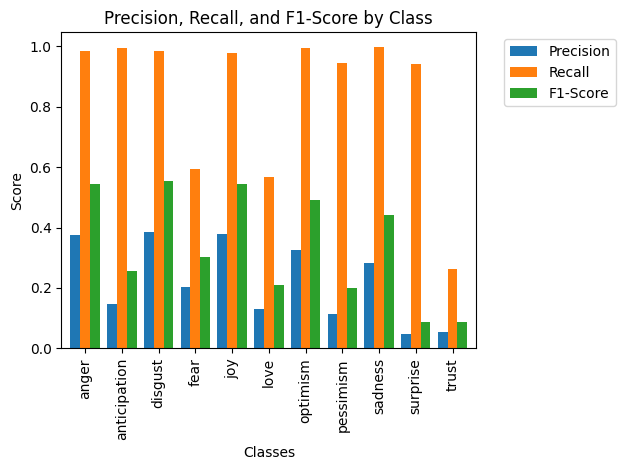

{'macro_avg': {'precision': 0.22157703238897966,
  'recall': 0.8408034870475946,
  'f1': 0.3382178345035297},
 'per_class': {'Precision': {'anger': 0.37600716204118173,
   'anticipation': 0.14708520179372198,
   'disgust': 0.3839928057553957,
   'fear': 0.20168067226890757,
   'joy': 0.3784505788067676,
   'love': 0.12956204379562045,
   'optimism': 0.32578397212543553,
   'pessimism': 0.11223551057957681,
   'sadness': 0.2828719723183391,
   'surprise': 0.046445497630331754,
   'trust': 0.053231939163498096},
  'Recall': {'anger': 0.9836065573770492,
   'anticipation': 0.9939393939393939,
   'disgust': 0.9861431870669746,
   'fear': 0.594059405940594,
   'joy': 0.9792626728110599,
   'love': 0.568,
   'optimism': 0.9946808510638298,
   'pessimism': 0.9457364341085271,
   'sadness': 0.9969512195121951,
   'surprise': 0.9423076923076923,
   'trust': 0.2641509433962264},
  'F1-Score': {'anger': 0.5440414507772021,
   'anticipation': 0.25625,
   'disgust': 0.5527508090614887,
   'fear': 0

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=label_columns, figsize=(12, 8))

## 7. Saving the Best Model

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 500.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/llama-3.2-1b/checkpoint-500'

## 8. Performance on Test Set

In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
test_set_tokenized = test_split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [ ]:
test_set_tokenized

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1159
})

In [ ]:
test_set_tokenized.set_format(type='torch')
test_set_tokenized = (test_set_tokenized
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    seed = 69,
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [ ]:
from functools import partial
compute_metrics_fn = partial(compute_metrics, thresholds=optimal_thresholds)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)

<ipython-input-256-b7cbf9c7164a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
# !pip install accelerate - U

In [ ]:
# !pip install transformers -U

In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

{'eval_loss': 0.9614043831825256,
 'eval_model_preparation_time': 0.0035,
 'eval_f1_micro': 0.48382590005373455,
 'eval_f1_macro': 0.44634178311517764,
 'eval_accuracy_label': 0.6232645697701781,
 'eval_accuracy_all': 0.004314063848144953,
 'eval_runtime': 1.1112,
 'eval_samples_per_second': 1043.055,
 'eval_steps_per_second': 9.0}

In [ ]:
wandb.log({"test_f1_macro": test_results["eval_f1_macro"], "test_loss": test_results["eval_loss"], "test_accuracy": test_results["eval_accuracy_all"]})

In [ ]:
test_output = trainer.predict(test_set_tokenized)

In [ ]:
test_preds = np.array((test_output.predictions > 0).astype(int))
test_labels = np.array(test_output.label_ids.astype(int))

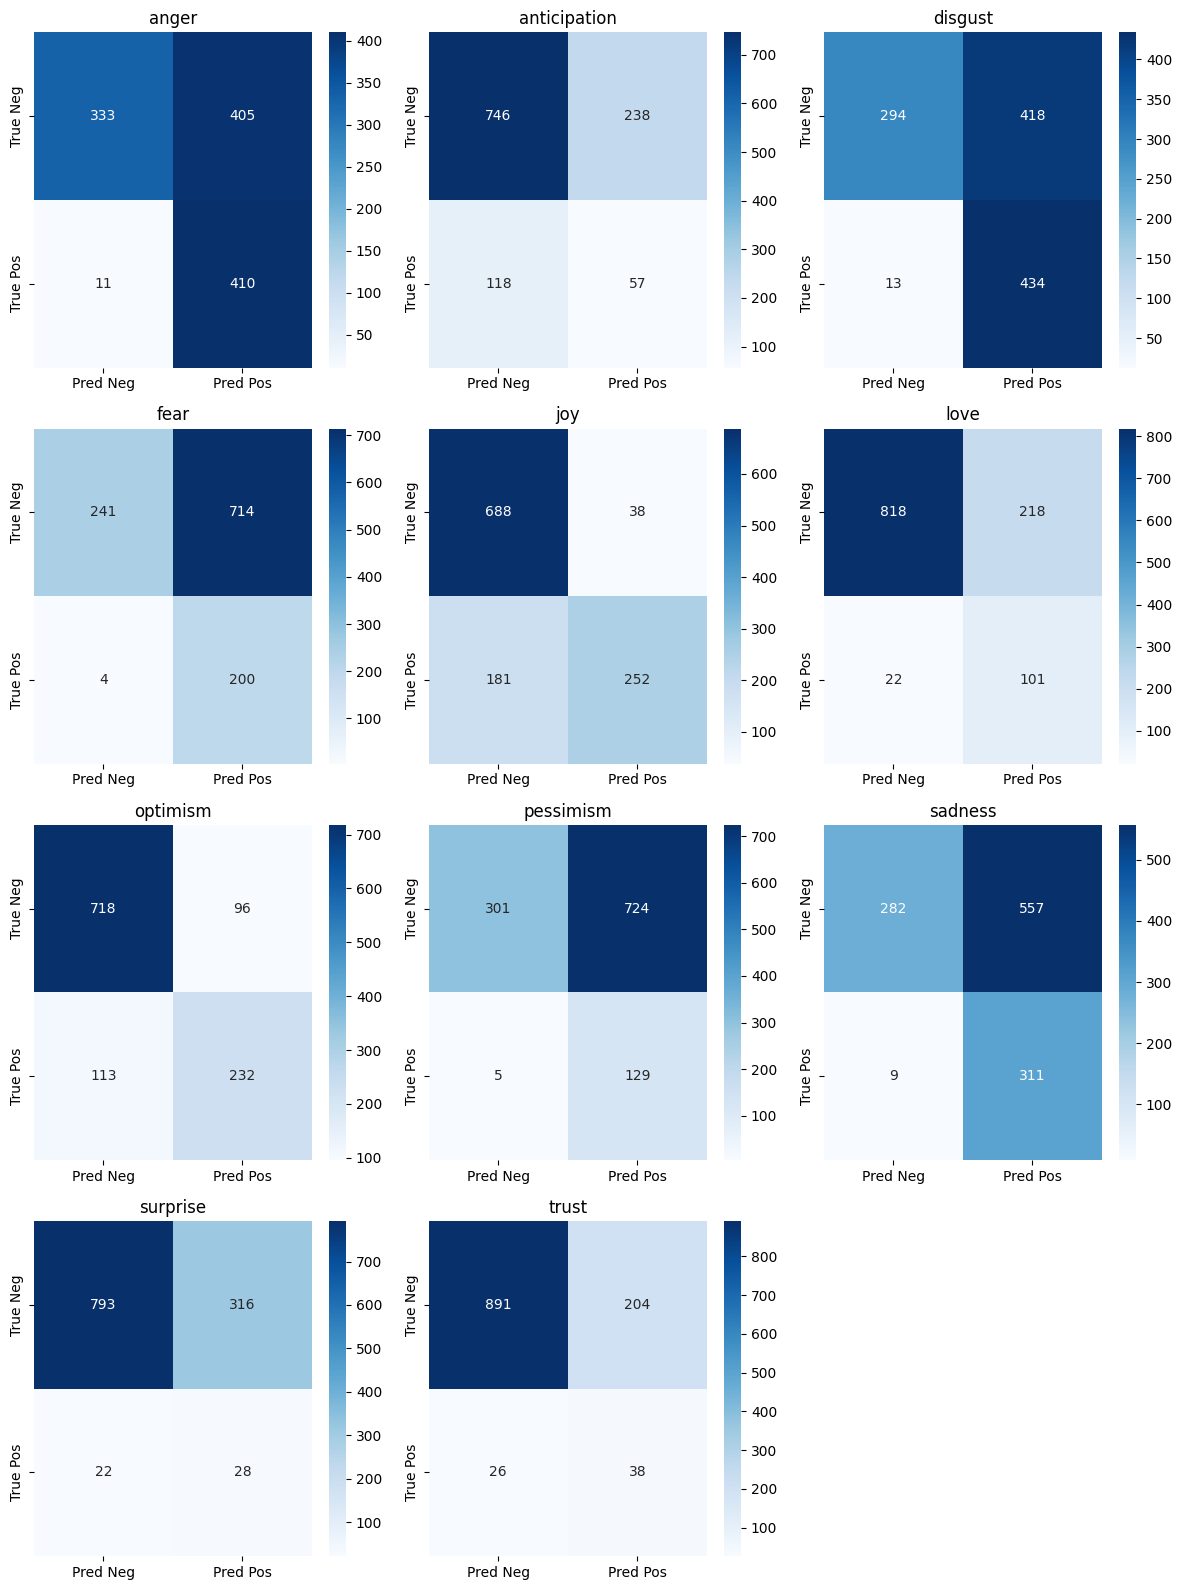

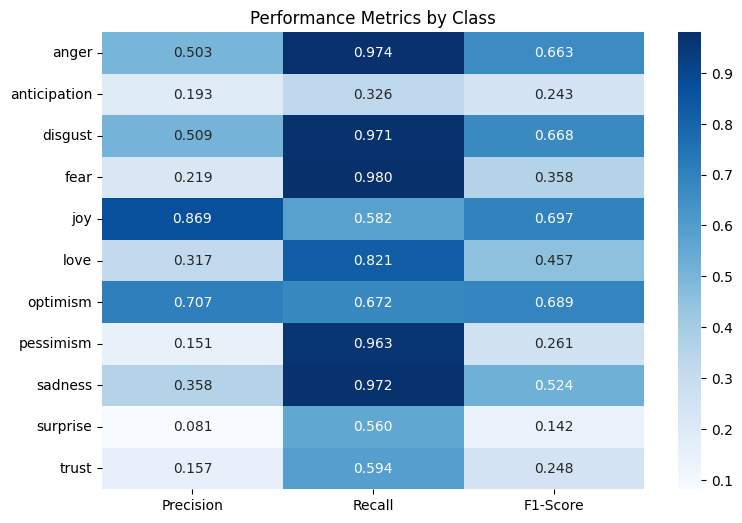

<Figure size 1200x533.333 with 0 Axes>

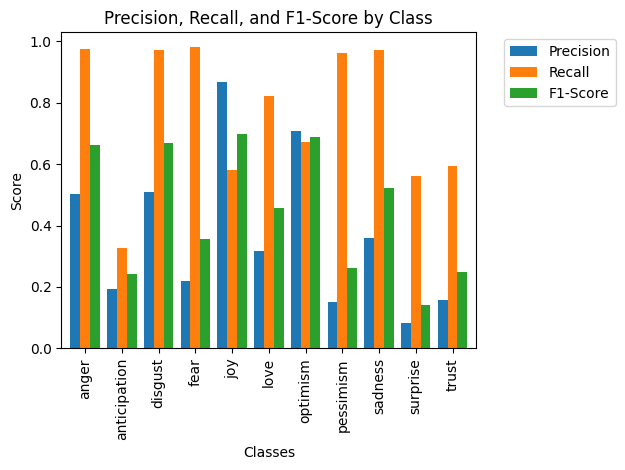

{'macro_avg': {'precision': 0.36957626444698344,
  'recall': 0.76498137203126,
  'f1': 0.45009055488509814},
 'per_class': {'Precision': {'anger': 0.5030674846625767,
   'anticipation': 0.19322033898305085,
   'disgust': 0.5093896713615024,
   'fear': 0.2188183807439825,
   'joy': 0.8689655172413793,
   'love': 0.3166144200626959,
   'optimism': 0.7073170731707317,
   'pessimism': 0.15123094958968347,
   'sadness': 0.358294930875576,
   'surprise': 0.08139534883720931,
   'trust': 0.15702479338842976},
  'Recall': {'anger': 0.9738717339667459,
   'anticipation': 0.32571428571428573,
   'disgust': 0.970917225950783,
   'fear': 0.9803921568627451,
   'joy': 0.581986143187067,
   'love': 0.8211382113821138,
   'optimism': 0.672463768115942,
   'pessimism': 0.9626865671641791,
   'sadness': 0.971875,
   'surprise': 0.56,
   'trust': 0.59375},
  'F1-Score': {'anger': 0.6634304207119741,
   'anticipation': 0.2425531914893617,
   'disgust': 0.6682063125481139,
   'fear': 0.35778175313059035,


In [ ]:
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_columns, figsize=(12, 8))

In [ ]:
wandb.finish()

eval/accuracy_all,▁▂▃▂▃▁▁▁▂▃▃▂▂▂█▆▅▇█▄▄▃▃▃▄▇█▇▇▆▅▆▆▄
eval/accuracy_label,▂▄▄▅▄▁▁▅▅▃▄▃▄▅▇▇▇▇█▇▆▄▄▃▅▇█▇▇▆▆▆▆▅
eval/f1_macro,▂▁▃▄▃▂▆▆▆▁▄▅▅▅▃▄▄▆▆▇▅▇█▇██▇▇▇▆▆▆▇█
eval/f1_micro,▁▂▃▃▃▂▃▆▅▂▄▅▅▅▅▅▄▅██▇▇▆▅▇▇█▇▆▅▅▅▆▇
eval/loss,▇█▅▄▄▅▄▆▄▅▅█▆▄▄▄▁▂▂▂▃▃▂▃▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂▃▃▂▂▂▂▂▂▁▂▂▂▂█▂▂▁▂▂▁▂▃▂▁▁▃▁▂▂▃▃▂▂
eval/samples_per_second,▇▆▆▇▇▇▇▇▇█▇▇▇▇▁▇▇█▇▇█▇▆▇██▆█▇▇▆▆▇▇
eval/steps_per_second,▇▆▆▇▇▇▇▇▇█▇▇▇▇▁▇▇█▇▇█▇▆▇██▆█▇▇▆▆▇▇
eval_accuracy,▁
eval_f1_macro,▁
eval_loss,▁


## 9. Model Inference

In [ ]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
# tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id
id2label= {id_: label_ for id_, label_ in enumerate(label_columns)}
label2id = {label_: id_ for id_, label_ in enumerate(label_columns)}
model.config.id2label = id2label
model.config.label2id = label2id

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForS

In [ ]:
test_split['text'][0]

'#Spina #Bifida a #neural #tube #birth #defect where the #nervous #system &amp; #spinal #cord do not fully develop #raredisease #June #awareness'

In [ ]:
sample = test_split['text'][0]
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.6406359076499939},
  {'label': 'anticipation', 'score': 0.37983837723731995},
  {'label': 'disgust', 'score': 0.6531268954277039},
  {'label': 'fear', 'score': 0.5827285051345825},
  {'label': 'joy', 'score': 0.2674081325531006},
  {'label': 'love', 'score': 0.314050555229187},
  {'label': 'optimism', 'score': 0.3363310694694519},
  {'label': 'pessimism', 'score': 0.5869964361190796},
  {'label': 'sadness', 'score': 0.66888028383255},
  {'label': 'surprise', 'score': 0.43950676918029785},
  {'label': 'trust', 'score': 0.3182732164859772}]]

In [ ]:
def get_positive_labels(pipeline_output, threshold=0.5):

    positive_labels = []

    for pred_set in pipeline_output:
        # Get labels where score >= threshold
        sample_positives = [pred['label'] for pred in pred_set
                          if pred['score'] >= threshold]
        positive_labels.append(sample_positives)

    return positive_labels

In [ ]:
results = get_positive_labels(preds, threshold=0.5)
results

[['anger', 'disgust', 'fear', 'pessimism', 'sadness']]

In [ ]:
preds = custom_pipeline(test_split['text'], truncation=True)

In [ ]:
preds[0:5]

[[{'label': 'anger', 'score': 0.6406359076499939},
  {'label': 'anticipation', 'score': 0.37983837723731995},
  {'label': 'disgust', 'score': 0.6531268954277039},
  {'label': 'fear', 'score': 0.5827285051345825},
  {'label': 'joy', 'score': 0.2674081325531006},
  {'label': 'love', 'score': 0.314050555229187},
  {'label': 'optimism', 'score': 0.3363310694694519},
  {'label': 'pessimism', 'score': 0.5869964361190796},
  {'label': 'sadness', 'score': 0.66888028383255},
  {'label': 'surprise', 'score': 0.43950676918029785},
  {'label': 'trust', 'score': 0.3182732164859772}],
 [{'label': 'anger', 'score': 0.671470582485199},
  {'label': 'anticipation', 'score': 0.35042139887809753},
  {'label': 'disgust', 'score': 0.6627964973449707},
  {'label': 'fear', 'score': 0.5841525197029114},
  {'label': 'joy', 'score': 0.24798741936683655},
  {'label': 'love', 'score': 0.29178744554519653},
  {'label': 'optimism', 'score': 0.29178744554519653},
  {'label': 'pessimism', 'score': 0.6020615696907043},

Testing

In [ ]:
test = pd.read_csv(data_folder /'test.csv')
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [ ]:
testset = Dataset.from_dict({
    'text': test['Tweet']})

In [ ]:
testset

Dataset({
    features: ['text'],
    num_rows: 3259
})

## 10. Submission for Kaggle

In [ ]:
tokenized__test_dataset= testset.map(tokenize_fn, batched=True)
tokenized_test_dataset = tokenized__test_dataset.remove_columns(
    ['text']
)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(tokenized_test_dataset)
predictions

PredictionOutput(predictions=array([[ 0.88671875, -0.53515625,  0.62109375, ...,  0.80859375,
        -0.44921875, -0.5859375 ],
       [ 0.7578125 , -0.546875  ,  0.71484375, ...,  0.93359375,
        -0.18066406, -0.81640625],
       [ 0.875     , -0.56640625,  0.7109375 , ...,  0.875     ,
        -0.36523438, -0.70703125],
       ...,
       [ 0.91015625, -0.578125  ,  0.625     , ...,  0.87109375,
        -0.28515625, -0.7265625 ],
       [-0.9375    ,  0.34179688, -0.5390625 , ..., -0.6015625 ,
         0.24023438,  0.40039062],
       [-0.890625  ,  0.35351562, -0.51171875, ..., -0.45507812,
         0.27539062,  0.3125    ]], dtype=float32), label_ids=None, metrics={'test_model_preparation_time': 0.0035, 'test_runtime': 1.8532, 'test_samples_per_second': 1758.586, 'test_steps_per_second': 14.03})

In [ ]:
predictions_test = pd.DataFrame((predictions.predictions > 0).astype(int), columns=label_columns)
predictions_test

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,0,1,1,0,0,0,1,1,0,0
1,1,0,1,1,0,0,0,1,1,0,0
2,1,0,1,1,0,0,0,1,1,0,0
3,1,0,1,1,0,0,0,1,1,0,0
4,1,0,1,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,1,0,0,0,1,1,0,0
3255,1,0,1,1,0,0,0,1,1,0,0
3256,1,0,1,1,0,0,0,1,1,0,0
3257,0,1,0,0,1,1,1,0,0,1,1


In [ ]:
submission = pd.concat([test['ID'], predictions_test], axis=1)

In [ ]:
submission.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,1,1,0,0
1,2018-03739,1,0,1,1,0,0,0,1,1,0,0
2,2018-00385,1,0,1,1,0,0,0,1,1,0,0
3,2018-03001,1,0,1,1,0,0,0,1,1,0,0
4,2018-01988,1,0,1,1,0,0,0,1,1,0,0


In [ ]:
submission.to_csv('llama3.2-1b.csv', index = False)

In [ ]:
from google.colab import files

files.download('llama3.2-1b.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>